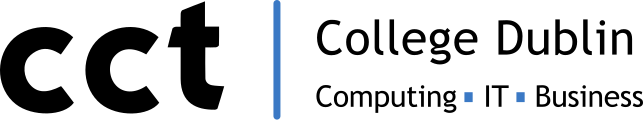

<div style="text-align: center;">
    <h2><u>Capstone Pair Project</u></h2>
    <h3> Problem Solving for Industry</h3>
    <h3>Supervisor: Dr Muhammad Iqbal</h3>
    <h3>Student Names: Danrlei Martins & Leonardo Diesel</h3>
    <h3>Student Numbers: 2020322 & 2020302</h3>
    <h3><a href="https://github.com/danrlei-martins-cct/CCT-Capstone-Project-FER">GitHub Repository</a></h3>
</div>

***

In [13]:
import os
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import keras
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Libraries Explanation


***

## 1. Data Understanding

In [2]:
train_dir = "FER2013/train/" # path with training images
test_dir = "FER2013/test/"   # path with testing images

In [3]:
# Exploring the different expressions (categories) of the FER2013 dataset
train_expressions = os.listdir(train_dir)
test_expressions = os.listdir(test_dir)

print("Expression Categories in Training Images:", train_expressions)
print("Expression Categories in Testing Images:", test_expressions)

Expression Categories in Training Images: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Expression Categories in Testing Images: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
# Dictionaries to store the image counts
train_image_counts = {expr: 0 for expr in train_expressions}
test_image_counts = {expr: 0 for expr in test_expressions}

# Count the number of images for each expression category
for expr in train_expressions:
    train_image_counts[expr] = len(os.listdir(os.path.join(train_dir, expr)))

for expr in test_expressions:
    test_image_counts[expr] = len(os.listdir(os.path.join(test_dir, expr)))
    
# Calculate the total number of images in the training and testing sets
total_train_images = sum(train_image_counts.values())
total_test_images = sum(test_image_counts.values())

# Print the results
print("\nNumber of Images per Category in Training Set:")
for expr, count in train_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Training Images: {total_train_images}")

print("\nNumber of Images per Category in Testing Set:")
for expr, count in test_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Testing Images: {total_test_images}")


Number of Images per Category in Training Set:
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171
Total Training Images: 28709

Number of Images per Category in Testing Set:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831
Total Testing Images: 7178


### 1.1 Exploratory Data Analysis (EDA)

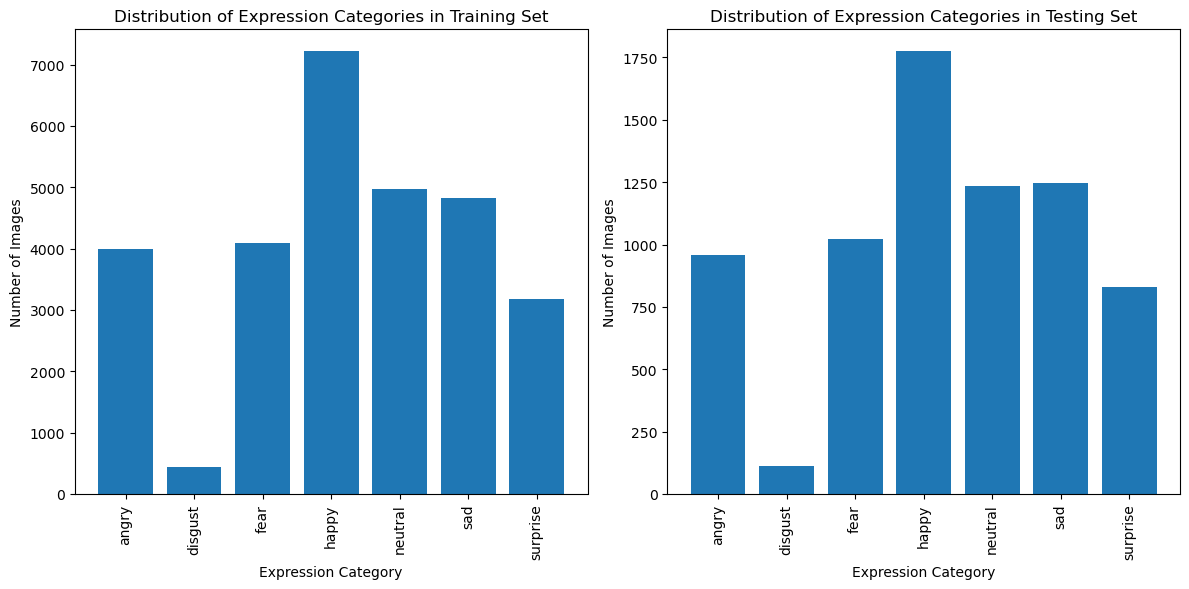

In [5]:
# Plot the distribution of expression categories in the sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(train_image_counts.keys(), train_image_counts.values())
plt.title("Distribution of Expression Categories in Training Set")
plt.xlabel("Expression Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=90);

plt.subplot(1, 2, 2)
plt.bar(test_image_counts.keys(), test_image_counts.values())
plt.title("Distribution of Expression Categories in Testing Set")
plt.xlabel("Expression Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

In [35]:
def visualize_img_samples(train_dir, num_samples_per_category):
    
    # Get the expression categories from the training directory
    train_expressions = os.listdir(train_dir)
    
    # Create a figure with subplots for each expression category
    fig, axes = plt.subplots(nrows=len(train_expressions), ncols=num_samples_per_category, figsize=(10, 10))
    
    # Iterate over the expression categories
    for i, expr in enumerate(train_expressions):
        # Get the path to the expression directory
        expr_dir = os.path.join(train_dir, expr)
        
        # Get the image files in the expression directory
        expr_files = os.listdir(expr_dir)
        
        # Randomly select sample images
        sample_image_files = random.sample(expr_files, num_samples_per_category)
        
        # Display the sample images
        for j, sample_image_file in enumerate(sample_image_files):
            sample_image = cv2.imread(os.path.join(expr_dir, sample_image_file))
            axes[i, j].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(expr)
            axes[i, j].axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.001)
    
    # Display the figure
    plt.tight_layout()
    plt.show()

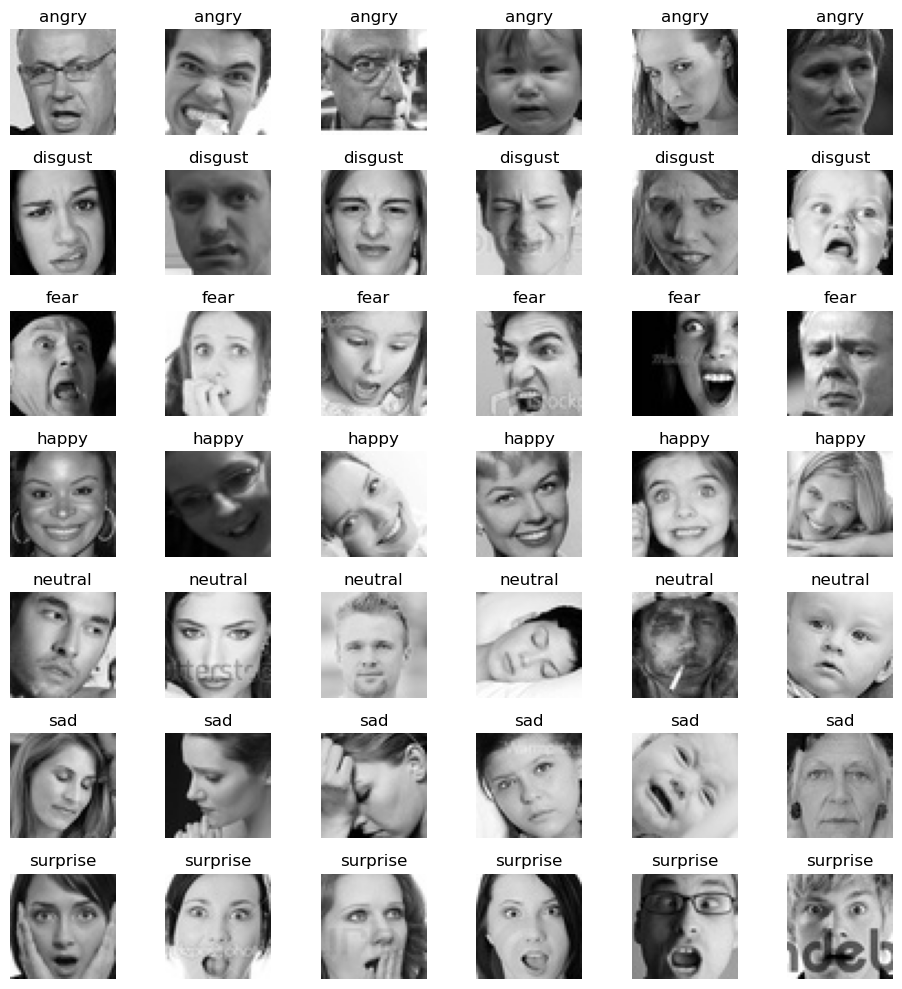

In [36]:
visualize_img_samples(train_dir, 6)

### 1.2 Findings

FER-2013 is an image contained dataset, all in 48x48 dimension where the faces were automatically registered, being centralized and categorized by emotions. There is an amount of 35,887 images, or faces, in this dataset and they are categorized by Angry (0), Disgust (1), Fear (2), Happy (3), Sad (4), Surprise (5) and Neutral (6). In these first steps we performed for the data understanding, two aspects strucked us; data imbalance and data accuracy.

For the first observations, it is clear that are imbalances in the dataset as the gap between the amount of images for the emotions Happy and Disgust is quite notable. 547 is the amount of images in the Disgust category and in contrast we find 8,989 images for the other category. There is as well a gap between Happy and the other remaining categories, which is not as big as the one just pointed, giving room for a possible balance in this amount what would may give less bias and overfitting to the future model, but as the first gap is quite large this balance might not be the best option. The best option is to train the model and see how it performs and with the results we are able to decide which way to go.

The accuracy aspect of the data comes when we sample a few random images from each of the emotions and could observe that not all of the images were accurate to their emotions. In some cases images/faces placed in the Happy category did not look to be a happy face, but a neutral, or a image place in the Fear category that does not resamble with the category. These are aspects that could change the accuracy of the model after the  training.

***

## 2. Data Preparation

### 2.1 Data Augmentation

In [12]:
# Define the preprocessing parameters for data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1 / 255.,        # Rescale pixel values to be between 0 and 1
    rotation_range = 15,       # Randomly rotate images by 0-20 degrees
    zoom_range = 0.1,          # Zoom to our object randomly
    horizontal_flip = True,    # Randomly flip images horizontally
    height_shift_range = 0.1,  # Shift the height of images by up to 10% randomly
    width_shift_range = 0.1,   # Shift the width of images by up to 10% randomly
    fill_mode = 'nearest',     # Replaces the empty area with the nearest pixel values
    validation_split = 0.2     # Set the validation split to 20%
)

test_datagen = ImageDataGenerator(
    rescale = 1 / 255.  # Rescale pixel values to [0, 1] range
)

In [37]:
def visualize_augmentation(train_datagen, train_dir, num_samples=10):

    # Get the expression categories from the training directory
    expression_categories = os.listdir(train_dir)
    
    # Create a figure with subplots for each expression category
    fig, axes = plt.subplots(nrows=len(expression_categories), ncols=num_samples + 1, figsize=(10, 10))
    
    # Iterate over the expression categories
    for i, expr in enumerate(expression_categories):
        # Get the path to the expression directory
        expr_dir = os.path.join(train_dir, expr)
        
        # Get the image files in the expression directory
        expr_files = os.listdir(expr_dir)
        
        # Randomly select a sample image
        sample_image_file = random.choice(expr_files)
        sample_image = cv2.imread(os.path.join(expr_dir, sample_image_file))
        
        # Display the original sample image
        axes[i, 0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f"Original ({expr})")
        axes[i, 0].axis('off')
        
        # Apply data augmentation and display the transformed images
        for j in range(1, num_samples + 1):
            # Apply data augmentation to the sample image
            augmented_image = train_datagen.random_transform(sample_image)
            
            # Display the transformed image
            axes[i, j].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(f"Augmented ({j})")
            axes[i, j].axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.001)
    
    # Display the figure
    plt.tight_layout()
    plt.show()

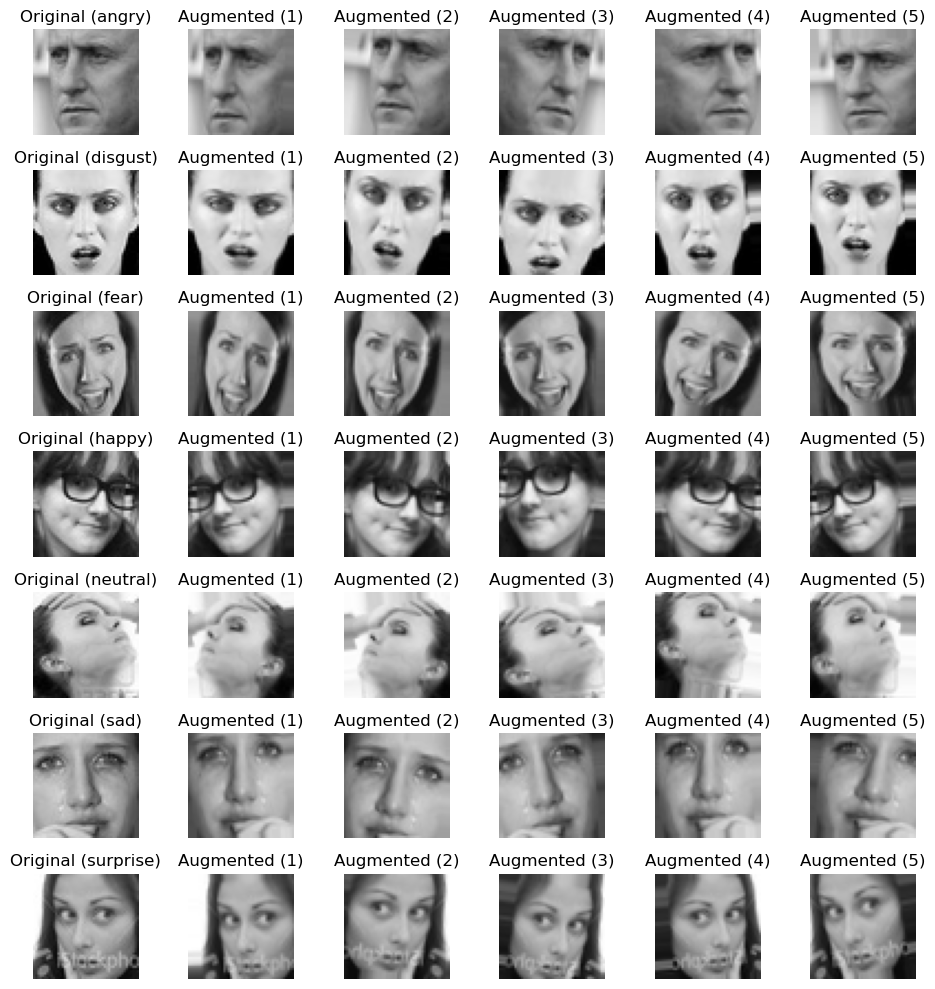

In [38]:
visualize_augmentation(train_datagen, train_dir, num_samples=5)